In [1]:
#!pip3 install tensorflow_datasets

In [2]:
import csv
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import h5py
import pickle

Tensorflow Version:  2.2.0


### Load the IMDB dataset from TF

In [3]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [4]:
print(type(imdb))
print(type(info))

<class 'dict'>
<class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>


### Read and prepare data

In [5]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [6]:
testing_labels_final.shape

(25000,)

In [7]:
training_labels_final.shape

(25000,)

In [8]:
unique_labels = set(training_labels)
unique_labels

{0, 1}

In [9]:
unique_labels = set(testing_labels)
unique_labels

{0, 1}

In [10]:
training_sentences[0:2]

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
 'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development wa

In [11]:
testing_sentences[0:2]

["There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.",
 "A blackly comic tale of a down-trodden priest, Nazarin

### Pre-processing

In [12]:
embedding_dim = 100
max_length = 100
padding_type='post'
trunc_type='post'
oov_tok = "<OOV>"


with open('saved_models/sentiment140_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

print('Words in the previously saved Tokenizer: ' + str(len(loaded_tokenizer.word_index)))
# loaded_tokenizer.fit_on_texts(training_sentences)

sequences = loaded_tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

word_index = loaded_tokenizer.word_index

testing_sequences = loaded_tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Words in the previously saved Tokenizer: 690961


In [13]:
print(padded.shape)
print(testing_padded.shape)

(25000, 100)
(25000, 100)


In [14]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_items = take(20, word_index.items())
print(n_items)

[('<OOV>', 1), ('i', 2), ('to', 3), ('the', 4), ('a', 5), ('my', 6), ('and', 7), ('you', 8), ('is', 9), ('it', 10), ('in', 11), ('for', 12), ('of', 13), ('on', 14), ('me', 15), ('so', 16), ('have', 17), ('that', 18), ('but', 19), ("i'm", 20)]


In [15]:
# print(sequences[1])
# print(padded[1])
# print(testing_sequences[1])
# print(testing_padded[1])

In [16]:
print(len(sequences[1]))
print(len(padded[1]))
print(len(testing_sequences[1]))
print(len(testing_padded[1]))

112
100
293
100


In [17]:
print(training_labels_final[0])
print(testing_labels_final[1])

print(training_labels_final.shape)
print(testing_labels_final.shape)

0
1
(25000,)
(25000,)


### Load previously trained Model

In [18]:
#pre_trained_model = tf.keras.models.load_model('saved_models/model_conv1D_LSTM')
#pre_trained_model.load_weights(local_weights_file)

pre_trained_model = tf.keras.models.load_model('saved_models/model_conv1D_LSTM_with_batch_100_epochs.h5')

# Show the model architecture
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           69096200  
_________________________________________________________________
conv1d (Conv1D)              (None, 9, 32)             25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                5

In [19]:
last_layer = pre_trained_model.get_layer('lstm')
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 32)


In [20]:
last_output = last_layer.output
print(last_output)

Tensor("lstm/Identity:0", shape=(None, 32), dtype=float32)


### Build new model

In [21]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
# x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(64, activation='relu')(last_output)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
#x = layers.Dense(6, activation='softmax')(x)      

x = layers.Flatten()(last_output)
#x = layers.LSTM(64)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x) 

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, 16)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 16, 100)           69096200  
_________________________________________________________________
conv1d (Conv1D)              (None, 9, 32)             25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0     

In [22]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), verbose=2)


Epoch 1/50


782/782 - 14s - loss: 0.5790 - acc: 0.6975 - val_loss: 0.5890 - val_acc: 0.7016
Epoch 2/50
782/782 - 12s - loss: 0.4889 - acc: 0.7692 - val_loss: 0.5192 - val_acc: 0.7376
Epoch 3/50
782/782 - 12s - loss: 0.4582 - acc: 0.7841 - val_loss: 0.4402 - val_acc: 0.7959
Epoch 4/50
782/782 - 12s - loss: 0.4350 - acc: 0.8003 - val_loss: 0.4318 - val_acc: 0.8008
Epoch 5/50
782/782 - 12s - loss: 0.4141 - acc: 0.8117 - val_loss: 0.4309 - val_acc: 0.8012
Epoch 6/50
782/782 - 12s - loss: 0.3967 - acc: 0.8210 - val_loss: 0.5194 - val_acc: 0.7607
Epoch 7/50
782/782 - 12s - loss: 0.3817 - acc: 0.8282 - val_loss: 0.4561 - val_acc: 0.7784
Epoch 8/50
782/782 - 12s - loss: 0.3689 - acc: 0.8364 - val_loss: 0.4901 - val_acc: 0.7820
Epoch 9/50
782/782 - 12s - loss: 0.3535 - acc: 0.8457 - val_loss: 0.4289 - val_acc: 0.8064
Epoch 10/50
782/782 - 12s - loss: 0.3428 - acc: 0.8516 - val_loss: 0.4437 - val_acc: 0.7864
Epoch 11/50
782/782 - 12s - loss: 0.3295 - acc: 0.8568 - val_loss: 0.4422 - val_acc: 0.8052
Epoch 12

In [23]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

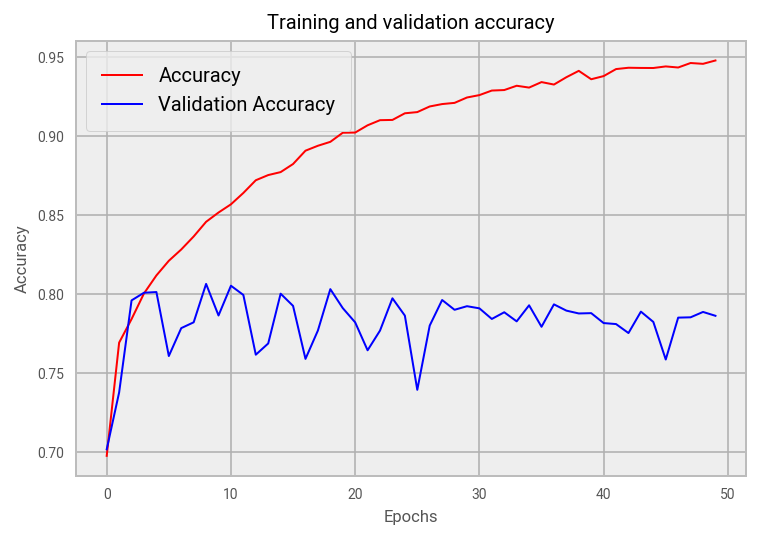

In [24]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

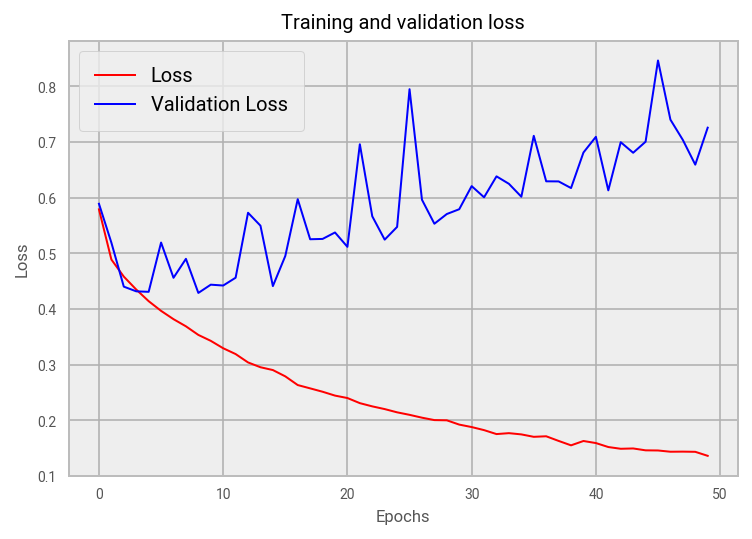

In [25]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

### Predictions

In [26]:
def text_prep(sent):
    print ("Input Sentence: " + sent)
    sent = np.array([sent])
    with open('saved_models/sentiment140_tokenizer.pickle', 'rb') as handle:
        loaded_tokenizer = pickle.load(handle)
    #loaded_tokenizer.fit_on_texts(sent)

    sequences = loaded_tokenizer.texts_to_sequences(sent)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded

def predict_sentiment(sent):
#  sent = input("Enter a sentence: ")
  #sent = "I've had a long day!"
  #sent = "The movie was inspired!"
    test_example = text_prep(sent)
    pred_conf = model.predict(test_example)
    pred_class = (model.predict(test_example) > 0.5).astype("int32")
    print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

In [27]:
test_sent = "The movie was inspired!"
predict_sentiment(test_sent)

Input Sentence: The movie was inspired!


1 sentiment; 99.446857% confidence


In [28]:
test_sent = "The movie is a masterpiece and the acting was brilliant"
predict_sentiment(test_sent)

Input Sentence: The movie is a masterpiece and the acting was brilliant
1 sentiment; 99.605238% confidence


In [29]:
test_sent = "The story was convoluted and way too twisted"
predict_sentiment(test_sent)

Input Sentence: The story was convoluted and way too twisted
0 sentiment; 4.981249% confidence


In [30]:
test_sent = "What a waste of time!"
predict_sentiment(test_sent)

Input Sentence: What a waste of time!
0 sentiment; 0.069640% confidence


In [31]:
test_sent = "This was such a waste of time!"
predict_sentiment(test_sent)

Input Sentence: This was such a waste of time!
0 sentiment; 0.114253% confidence


In [32]:
test_sent = "Nolan is the greatest director I've known"
predict_sentiment(test_sent)

Input Sentence: Nolan is the greatest director I've known
1 sentiment; 99.476349% confidence


In [33]:
test_sent = "Shawshank might be a great movie, but you can't beat Interstellar!"
predict_sentiment(test_sent)

Input Sentence: Shawshank might be a great movie, but you can't beat Interstellar!
0 sentiment; 3.901092% confidence


In [34]:
test_sent = "It was too slow!"
predict_sentiment(test_sent)

Input Sentence: It was too slow!
0 sentiment; 3.833594% confidence


In [35]:
test_sent = "The Devil, indeed, was in the detail!"
predict_sentiment(test_sent)

Input Sentence: The Devil, indeed, was in the detail!
1 sentiment; 95.571864% confidence


In [36]:
test_sent = "Everybody at the theatre could not wait for it to be over"
predict_sentiment(test_sent)

Input Sentence: Everybody at the theatre could not wait for it to be over
0 sentiment; 3.957615% confidence


In [37]:
test_sent = "I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else."
predict_sentiment(test_sent)

Input Sentence: I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else.
0 sentiment; 15.965901% confidence


In [38]:
test_sent = "The film's last scenes, in which he casts doubt on his behaviour and, in a split second, has to choose between the life he has been leading or the conventional life that is expected of a priest, are so emotional because they concern his moral integrity and we are never quite sure whether it remains intact or not."
predict_sentiment(test_sent)

Input Sentence: The film's last scenes, in which he casts doubt on his behaviour and, in a split second, has to choose between the life he has been leading or the conventional life that is expected of a priest, are so emotional because they concern his moral integrity and we are never quite sure whether it remains intact or not.
1 sentiment; 74.409443% confidence


In [39]:
test_sent = "If you haven't seen this movie see it right now!"
predict_sentiment(test_sent)

Input Sentence: If you haven't seen this movie see it right now!
1 sentiment; 71.349251% confidence


In [41]:
test_sent = "I went into this not expecting to much but I came out blown away."
predict_sentiment(test_sent)

Input Sentence: I went into this not expecting to much but I came out blown away.
0 sentiment; 3.981869% confidence


In [43]:
test_sent = "Film surpasses the hype!"
predict_sentiment(test_sent)

Input Sentence: Film surpasses the hype!
0 sentiment; 4.073040% confidence


In [44]:
test_sent = "It is a movie worth seeing due to the fact that the workers put so much time and effort into this one film and they did not want to waste money putting up garbage."
predict_sentiment(test_sent)

Input Sentence: It is a movie worth seeing due to the fact that the workers put so much time and effort into this one film and they did not want to waste money putting up garbage.
1 sentiment; 56.815416% confidence


In [45]:
results = model.evaluate(padded, training_labels_final, verbose=0)
print("Training Accuracy: "+ str(results[1]*100) + ' %')
print("Training Loss: {:0.4f}".format(results[0]))

Training Accuracy: 98.73999953269958 %
Training Loss: 0.0479


In [46]:
val_results = model.evaluate(testing_padded, testing_labels_final, verbose=0)
print("Validation Accuracy: " + str(val_results[1]*100) + ' %')
print("Validation Loss: {:0.4f}".format(val_results[0]))

Validation Accuracy: 78.61599922180176 %
Validation Loss: 0.7258


In [47]:
# def test_preproc(sent):
#     print ("Input Sentence: " + sent)
#     sent = np.array([sent])
#     with open('saved_models/sentiment140_tokenizer.pickle', 'rb') as handle:
#         loaded_tokenizer = pickle.load(handle)
#     #loaded_tokenizer.fit_on_texts(sent)

#     sequences = loaded_tokenizer.texts_to_sequences(sent)
#     print(sequences)
#     padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#     print(padded)
#     return padded

# def test_prediction(sent):
# #  sent = input("Enter a sentence: ")
#   #sent = "I've had a long day!"
#   #sent = "The movie was inspired!"
#     test_example = test_preproc(sent)
#     pred_conf = model.predict(test_example)
#     pred_class = (model.predict(test_example) > 0.5).astype("int32")
#     print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

In [48]:
# test_sent = "The movie showed an invaluable talent"
# test_prediction(test_sent)

In [49]:
# word_index['talent']